In [1]:
import tensorflow as tf
import os
import random
import shutil
import matplotlib.pyplot as plt
import numpy as np

tf.random.set_seed(1)
random.seed(1)

In [2]:
PATH ='./data/dogs-vs-cats/'

train_dir = os.path.join(PATH, 'train')
valid_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

In [3]:
train_len = len(os.listdir(train_dir))
valid_len = len(os.listdir(valid_dir))
test_len = len(os.listdir(test_dir))

In [4]:
print('total training images:', train_len)
print('total validation images:', valid_len)
print('total testing images:', test_len)

total training images: 20000
total validation images: 5000
total testing images: 12500


In [5]:
CLASS_NAMES = ["cat", "dog"]

EPOCH_SIZE = 5
BATCH_SIZE = 32
BUFFER_SIZE= BATCH_SIZE * 5
STEPS_PER_EPOCH = train_len//BATCH_SIZE
VALIDATION_STEPS = valid_len//BATCH_SIZE
IMG_HEIGHT = 128
IMG_WIDTH = 128

In [6]:
def process_label(path):
    label = tf.strings.split(path, os.path.sep)[-1]
    label = tf.strings.split(label, ".")[0]
    return tf.cast(label == CLASS_NAMES, tf.float32)

def process_image(path):
    image = tf.io.read_file(path)
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return tf.image.resize(image, [IMG_WIDTH, IMG_HEIGHT])

def scale_image(image):
    return tf.image.per_image_standardization(image)

def process_data(path):
    image = process_image(path)
    image = scale_image(image)
    label = process_label(path)
    
    return image, label

def input_fn(path):
    list_ds = tf.data.Dataset.list_files(str(path))
    return list_ds \
        .map(process_data) \
        .shuffle(BUFFER_SIZE) \
        .batch(BATCH_SIZE) \
        .prefetch(buffer_size=tf.data.experimental.AUTOTUNE) \
        .repeat(EPOCH_SIZE)

In [7]:
train_ds = input_fn(os.path.join(train_dir, "*.jpg")).take(5000)
valid_ds = input_fn(os.path.join(valid_dir, "*.jpg")).take(2000)

W0424 22:20:31.200862 140735961576320 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow_core/python/ops/image_ops_impl.py:1518: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [11]:
def model_fn():
    model = tf.keras.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(), 
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  
    ])

    model.compile(optimizer=tf.optimizers.Adam(lr=5e-4),
                  loss=tf.losses.CategoricalCrossentropy(), 
                  metrics=["accuracy"])
    
    return model

In [12]:
model = model_fn()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [13]:
history = model.fit(train_ds,
                    validation_data=valid_ds,
                    validation_steps=int(2000 / BATCH_SIZE),
                    epochs = EPOCH_SIZE, 
                    steps_per_epoch = int(5000 / BATCH_SIZE), 
                    use_multiprocessing=True, 
                    workers=7)

Train for 156 steps, validate for 62 steps
Epoch 1/5
156/156 [==============================] - 35s 226ms/step - loss: 0.7390 - accuracy: 0.5719 - val_loss: 0.6061 - val_accuracy: 0.6850
Epoch 2/5
156/156 [==============================] - 36s 231ms/step - loss: 0.5929 - accuracy: 0.6769 - val_loss: 0.5904 - val_accuracy: 0.6714
Epoch 3/5
156/156 [==============================] - 35s 226ms/step - loss: 0.5440 - accuracy: 0.7244 - val_loss: 0.5175 - val_accuracy: 0.7399
Epoch 4/5
156/156 [==============================] - 35s 226ms/step - loss: 0.5232 - accuracy: 0.7364 - val_loss: 0.4899 - val_accuracy: 0.7646
Epoch 5/5
156/156 [==============================] - 36s 233ms/step - loss: 0.4602 - accuracy: 0.7839 - val_loss: 0.4968 - val_accuracy: 0.7601


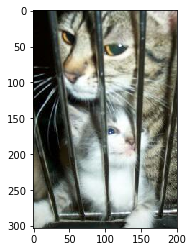

'cat'

In [14]:
def predict(path, plot_img = False):
    if plot_img:
        img = tf.io.read_file(path)
        img = tf.image.decode_jpeg(img)
        plt.imshow(img)
        plt.show()
        
    img = next(iter(process_data(path)))
    x = np.expand_dims(img, axis=0)
    classes = model.predict(x)
    return "cat" if np.argmax(classes) == 0 else "dog"

predict(os.path.join(test_dir, os.listdir(test_dir)[1]), True)

In [15]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[0:]]

#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
img = next(iter(process_data(os.path.join(test_dir, os.listdir(test_dir)[1]))))
x = np.expand_dims(img, axis=0)
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers]

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


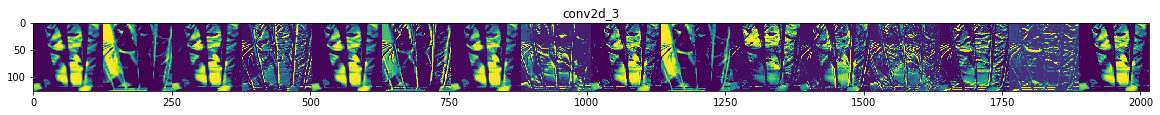

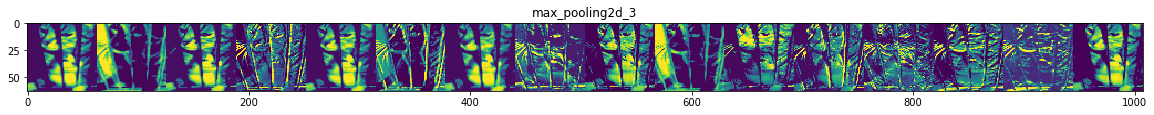

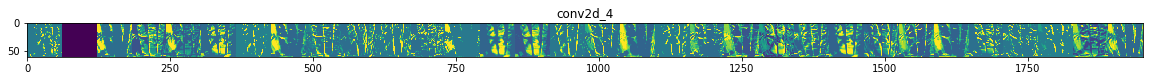

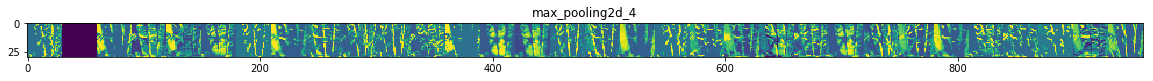

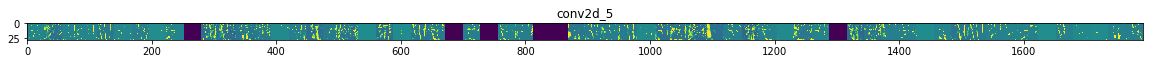

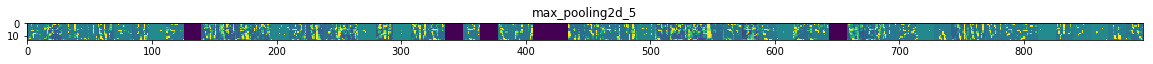

In [16]:
# -----------------------------------------------------------------------
# Now let's display our representations
# -----------------------------------------------------------------------
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  
  if len(feature_map.shape) == 4:
        #-------------------------------------------
        # Just do this for the conv / maxpool layers, not the fully-connected layers
        #-------------------------------------------
        n_features = feature_map.shape[-1]  # number of features in the feature map
        size       = feature_map.shape[ 1]  # feature map shape (1, size, size, n_features)
        
        # We will tile our images in this matrix
        display_grid = np.zeros((size, size * n_features))
        
        #-------------------------------------------------
        # Postprocess the feature to be visually palatable
        #-------------------------------------------------
        for i in range(n_features):
            x  = feature_map[0, :, :, i]
            x -= x.mean()
            x /= x.std ()
            x *=  64
            x += 128
            x  = np.clip(x, 0, 255).astype('uint8')
            display_grid[:, i * size : (i + 1) * size] = x # Tile each filter into a horizontal grid
        
        #-----------------
        # Display the grid
        #-----------------

        scale = 20. / n_features
        plt.figure( figsize=(scale * n_features, scale) )
        plt.title ( layer_name )
        plt.grid  ( False )
        plt.imshow( display_grid, aspect='auto', cmap='viridis' ) 